## Final Project Submission

Please fill out:
* Student name: Sabina Bains
* Student pace: self paced
* Scheduled project review date/time: 
* Instructor name: Claude Fried
* Blog post URL: 


In [2]:
# Import Standard Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import statistics
import os

In [43]:
%matplotlib inline

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-talk')

Notes:

imdb variable explanation: https://www.imdb.com/interfaces/

In [4]:
#Viewing and changing filenames for easier file importing
filenames = os.listdir('zippedData')
paths = []

for file in filenames:
    paths.append('zippeddata/'+file)
    
for num, name in enumerate(paths):
    print(num, name)

0 zippeddata/imdb.title.crew.csv.gz
1 zippeddata/imdb.title.basics.tsv.gz
2 zippeddata/tmdb.movies.csv.gz
3 zippeddata/imdb.title.akas.csv.gz
4 zippeddata/imdb.title.ratings.csv.gz
5 zippeddata/imdb.name.basics.csv.gz
6 zippeddata/rt.reviews.tsv.gz
7 zippeddata/imdb.title.basics.csv.gz
8 zippeddata/rt.movie_info.tsv.gz
9 zippeddata/tn.movie_budgets.csv.gz
10 zippeddata/bom.movie_gross.csv.gz
11 zippeddata/imdb.title.principals.csv.gz


# SUGGESTION #1:

## Focus on creating movies in the News, Documentary, or Biography Genre

- These Genres have the highest average rating


### Notes:
    -We should filter on whether each individual IMDB rating has >30? count
    -Should filter on how many average ratings are in each genre (>10?)


In [5]:
# Importing Ratings Data
ratings = pd.read_csv(paths[4])

In [8]:
# Importing Genre Data and Filtering on Type = Movie
genres = pd.read_csv(paths[1],sep="\t",low_memory=False)
genres = genres.loc[genres['titleType']=='movie']
genres

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
610,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama
625,tt0000630,movie,Hamlet,Amleto,0,1908,\N,\N,Drama
...,...,...,...,...,...,...,...,...,...
8230824,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,\N,57,Documentary
8230851,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,\N,100,Documentary
8230863,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,\N,Comedy
8230874,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,\N


In [12]:
# Merging genre column to ratings info
imdb = pd.merge(ratings, genres, on='tconst', how='inner')

In [13]:
#checking for duplicates and N/A's
imdb.isna().sum()

tconst            0
averagerating     0
numvotes          0
titleType         0
primaryTitle      0
originalTitle     0
isAdult           0
startYear         0
endYear           0
runtimeMinutes    0
genres            0
dtype: int64

In [14]:
imdb.duplicated().sum()

0

<AxesSubplot:>

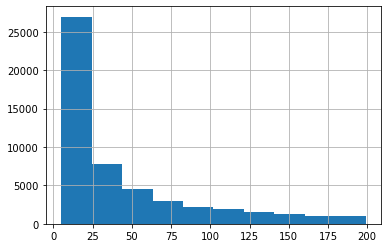

In [17]:
imdb.loc[imdb['numvotes']<200]['numvotes'].hist()

In [45]:
#### QUESTION - Should we filter out low numvotes? If so use this code
imdb['numvotes'].describe().astype(int)
imdb = imdb.loc[imdb['numvotes'] > 25]

imdb.shape

(36440, 14)

In [21]:
#Since the genre column has multiple tags, I am splitting into multiple columns by "," separator
imdb_split = imdb['genres'].str.split(',', expand=True).add_prefix('genre').fillna('')
imdb = imdb.join(imdb_split)
imdb.head()

,tconst,averagerating,numvotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genre0,genre1,genre2
1,tt10384606,8.9,559,movie,Borderless,Borderless,0,2019,\N,87,Documentary,Documentary,,
3,tt1043726,4.2,50352,movie,The Legend of Hercules,The Legend of Hercules,0,2014,\N,99,"Action,Adventure,Fantasy",Action,Adventure,Fantasy
5,tt1069246,6.2,326,movie,Habana Eva,Habana Eva,0,2010,\N,106,"Comedy,Romance",Comedy,Romance,
6,tt1094666,7.0,1613,movie,The Hammer,Hamill,0,2010,\N,108,"Biography,Drama,Sport",Biography,Drama,Sport
7,tt1130982,6.4,571,movie,The Night Clerk,Avant l'aube,0,2011,\N,104,"Drama,Thriller",Drama,Thriller,


In [22]:
#Creating Deduplicated list of Genres to use as Keys for Dictionary
genre_list = imdb.genres.str.split(',').to_list()
genre_list = list(set(list(chain.from_iterable(genre_list))))

In [23]:
#creating dictionary to map ratings to genres
ratings_dict={}
for item in genre_list:
    ratings_dict[item] = []

In [24]:
# Appending Average Rating to Dictionary of Genres
for genre in genre_list:
    for index, row in imdb.iterrows():
        if imdb['genre0'][index] == genre:
            ratings_dict[row['genre0']].append(row['averagerating'])
        elif imdb['genre1'][index] == genre:
            ratings_dict[row['genre1']].append(row['averagerating'])
        elif imdb['genre2'][index] == genre:
            ratings_dict[row['genre2']].append(row['averagerating'])

In [26]:
# previewing dictionary
for i in ratings_dict:
    print(i, ratings_dict[i][:5])

Biography [7.0, 7.6, 6.6, 7.7, 7.8]
Sport [7.0, 7.6, 6.2, 7.3, 7.2]
Fantasy [4.2, 6.5, 7.0, 5.6, 5.4]
Drama [7.0, 6.4, 7.2, 5.8, 7.0]
Music [5.2, 7.5, 7.0, 6.4, 8.5]
Documentary [8.9, 6.2, 7.7, 6.7, 7.5]
Mystery [7.4, 2.4, 6.5, 5.1, 7.5]
Horror [5.6, 3.4, 5.1, 3.6, 3.5]
Sci-Fi [4.2, 5.8, 4.6, 7.0, 4.7]
Animation [7.0, 5.0, 6.1, 5.5, 6.1]
News [7.3, 7.8, 8.7, 7.4, 8.2]
Adult [6.9, 7.4, 7.4, 2.0]
Western [4.3, 6.2, 6.0, 7.6, 6.5]
Thriller [6.4, 5.5, 7.4, 5.8, 5.6]
Family [5.4, 6.5, 3.4, 5.5, 4.4]
Romance [6.2, 5.1, 5.8, 6.5, 5.4]
War [7.2, 6.5, 6.5, 7.7, 2.4]
Action [4.2, 4.2, 7.4, 7.2, 4.5]
Musical [5.8, 4.9, 5.2, 7.2, 4.6]
History [6.2, 6.2, 6.4, 6.3, 7.3]
Crime [7.2, 6.1, 4.5, 6.2, 5.4]
Comedy [6.2, 5.1, 5.8, 5.0, 7.2]
\N [7.5, 6.5, 8.6, 1.0, 7.9]
Reality-TV [4.8]
Adventure [4.2, 4.2, 7.0, 5.0, 7.4]


In [27]:
# calculating count of movies in each genre (as we should exclude genre if it doesn't have many movies represented)
count_dict = ratings_dict.copy()

for i in ratings_dict:
    count_dict[i] = len(ratings_dict[i])

In [28]:
# calculating average rating per Genre
avg_ratings_dict = {}
for i in ratings_dict:
    avg_ratings_dict[i] = statistics.mean(ratings_dict[i])

In [29]:
# Turning Ratings Dict into DF for Boxplot
genre_ratings_df = pd.DataFrame.from_dict(ratings_dict, orient = "index").sort_index().stack().reset_index(level=1, drop=True).reset_index()
genre_ratings_df.columns = ['Genre','Average Rating']

In [30]:
#creating df from ratings column from dictionary
genre_rating = pd.DataFrame(avg_ratings_dict,index=['Average Rating'])
genre_rating = genre_rating.transpose()
genre_rating = genre_rating.reset_index()

In [32]:
genre_rating.head()

,index,Average Rating
0,Biography,6.929905
1,Sport,6.688279
2,Fantasy,5.629291
3,Drama,6.202077
4,Music,6.786524


In [33]:
#creating df with count column from dictionary
genre_count = pd.DataFrame(count_dict,index=['Count'])
genre_count = genre_count.transpose()
genre_count = genre_count.reset_index()

In [34]:
genre_count.head()

,index,Count
0,Biography,1886
1,Sport,674
2,Fantasy,1369
3,Drama,17576
4,Music,935


In [35]:
# final merge onto genre column for analysis
genre = pd.merge(genre_rating,genre_count, on="index")
genre.rename(columns={'index':'Genre'},inplace=True)
genre.head()

,Genre,Average Rating,Count
0,Biography,6.929905,1886
1,Sport,6.688279,674
2,Fantasy,5.629291,1369
3,Drama,6.202077,17576
4,Music,6.786524,935


In [36]:
# filtering out any genre column that has less than 10 movies represented and sorting by highest rating
genre = genre.loc[genre['Count'] >= 10].reset_index(drop=True)
genre = genre.sort_values('Average Rating', ascending = False)

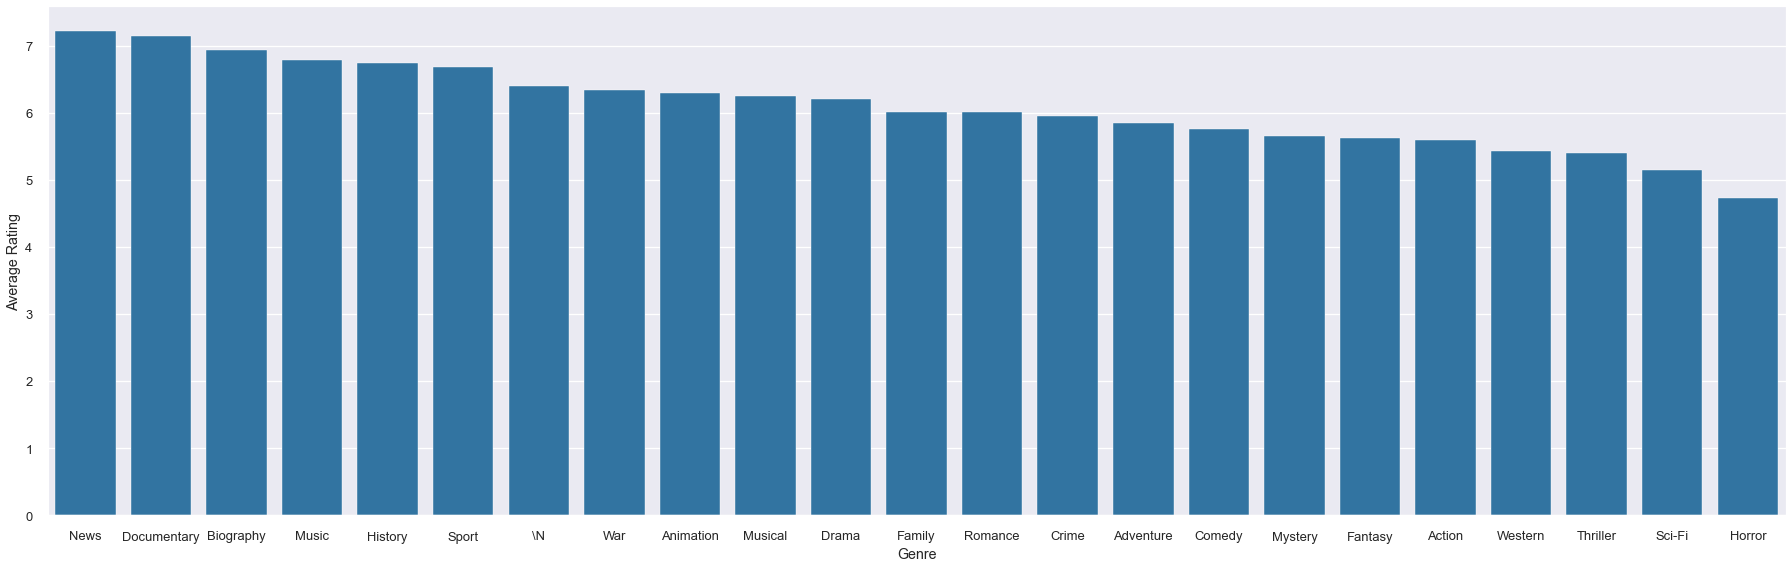

In [47]:
# Bar Plot of Ratings by Genre
fig, ax = plt.subplots(figsize=(25,8))
sns.barplot(x = 'Genre',
            y = 'Average Rating',
            data = genre,
            ax = ax,
            color = 'tab:blue')
fig.tight_layout()

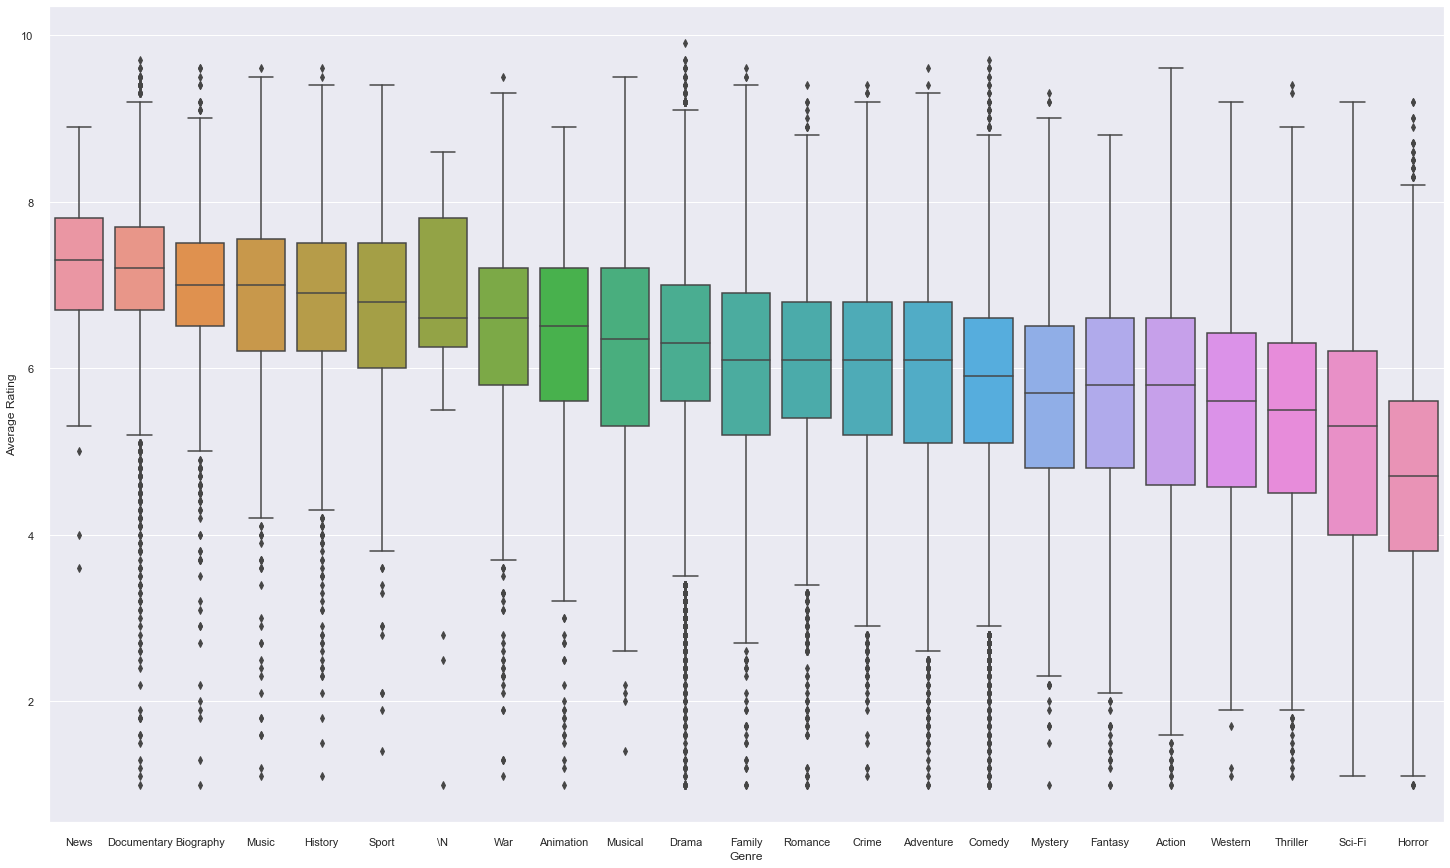

In [49]:
# Boxplot of Ratings by Genre
ax = sns.boxplot(x='Genre', y="Average Rating", data=genre_ratings_df, order=genre['Genre'].tolist())

In [ ]:
def top_in_genre(genre):
    cols=['genres','primaryTitle','averagerating','numvotes','isAdult','startYear','runtimeMinutes']
    df = imdb[cols]
    df = df.copy()
    df = df.loc[df['genres'].str.contains(genre)]
    df = df.sort_values(by='averagerating',ascending=False).head()
    return df

In [ ]:
top_in_genre('Horror')

In [ ]:
# genre_ratings_df.groupby('Genre').std().sort_values(by='Average Rating', ascending=False)

# 2

## crew w highest ratings

- join nconst with ratings to see which writers / directors have the most success.

In [ ]:
#read in data
namebasics = pd.read_csv(paths[5])
titlecrew = pd.read_csv(paths[0])
titleps = pd.read_csv(paths[11])
titleakas = pd.read_csv(paths[3])
titleakas=titleakas.rename(columns={'title_id':'tconst'})

In [ ]:
crew = pd.merge(titleps,namedetails,on='nconst',how='left')
crew = crew.drop_duplicates()

In [ ]:
crew = pd.merge(crew,titleakas,on='tconst',how='left')
crew2 = pd.merge(crew,imdb,on='tconst',how='left')
crew_cols = ['category','nconst', 'tconst','characters',
       'primary_name','known_for_titles','averagerating','numvotes','genres','region']
crew2 = crew2[crew_cols]
crew3 = crew2.loc[~crew2['averagerating'].isnull()]

In [ ]:
crew4 = crew3.loc[crew3['numvotes']>10000]

In [ ]:
a_list = ['actor','actress']
actor = crew4.loc[crew4['category'].isin(a_list)]
actor = actor.loc[actor['region']=='US']
# actor.sort_values('numvotes',ascending=False)

In [ ]:
actor_group = actor.groupby('primary_name')['averagerating'].agg(['mean','count']).reset_index()

In [ ]:
a = actor_group.loc[actor_group['count']>2]
a = a.sort_values('mean',ascending=False).head(10)

In [ ]:
# Bar Plot of Ratings by Actor
sns.barplot(x = 'primary_name',
            y = 'mean',
            data = a)
 
sns.set(rc={'figure.figsize':(25,8)})
# plt.show()

In [45]:
#working test
df = pd.DataFrame({'A':[1,2,3,4],'B':['sab,mom','shay','simmy,dad,missi','mom,dad']})
namedict={'sab':[],'mom':[],'shay':[],'simmy':[],'dad':[],'missi':[]}

In [ ]:
for index, row in df.iterrows():
    for name in namedict:
        if name in row['B']:
            namedict[name].append(row['A'])

In [ ]:
#test for another proj I be working on:
#subracting by previous row 
import pandas as pd

#creating fake DF 
df = pd.DataFrame({'A':[1,2,3,4],'B':[10,21,33,46]})

#Creating new column and setting to 0 for now
df['C'] = 0

#using .loc to grab subract value in the current row for column B by the previous row for column B
for i in range(1, len(df)):
    df.loc[i, 'C'] = df.loc[i, 'B']- df.loc[i-1, 'B']
    
df

#  # 3:



In [90]:
profit = pd.read_csv(paths[9])

In [91]:
# profit['release_date'].astype(int)
type(profit['release_date'][0])

str

In [98]:
profit['startYear'] = profit['release_date'].map(lambda x : x[-4:])
profit.rename(columns={'movie':'primaryTitle'}, inplace=True)

In [107]:
merge_list=['primaryTitle','startYear']
f = pd.merge(imdb,profit,on=merge_list,how='inner')

In [109]:
# f.isna().sum()
f

,tconst,averagerating,numvotes,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,genre0,genre1,genre2,id,release_date,production_budget,domestic_gross,worldwide_gross
0,tt1043726,4.2,50352,movie,The Legend of Hercules,The Legend of Hercules,0,2014,\N,99,"Action,Adventure,Fantasy",Action,Adventure,Fantasy,42,"Jan 10, 2014","$70,000,000","$18,848,538","$58,953,319"
1,tt1171222,5.1,8296,movie,Baggage Claim,Baggage Claim,0,2013,\N,96,"Comedy,Romance",Comedy,Romance,,38,"Sep 27, 2013","$8,500,000","$21,569,509","$22,885,836"
2,tt1210166,7.6,326657,movie,Moneyball,Moneyball,0,2011,\N,133,"Biography,Drama,Sport",Biography,Drama,Sport,15,"Sep 23, 2011","$50,000,000","$75,605,492","$111,300,835"
3,tt1212419,6.5,87288,movie,Hereafter,Hereafter,0,2010,\N,129,"Drama,Fantasy,Romance",Drama,Fantasy,Romance,61,"Oct 15, 2010","$50,000,000","$32,746,941","$108,660,270"
4,tt1232829,7.2,477771,movie,21 Jump Street,21 Jump Street,0,2012,\N,109,"Action,Comedy,Crime",Action,Comedy,Crime,44,"Mar 16, 2012","$42,000,000","$138,447,667","$202,812,429"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1446,tt2386490,7.6,60769,movie,How to Train Your Dragon: The Hidden World,How to Train Your Dragon: The Hidden World,0,2019,\N,104,"Action,Adventure,Animation",Action,Adventure,Animation,56,"Feb 22, 2019","$129,000,000","$160,791,800","$519,258,283"
1447,tt2704998,7.0,163279,movie,Game Night,Game Night,0,2018,\N,100,"Action,Comedy,Crime",Action,Comedy,Crime,94,"Feb 23, 2018","$37,000,000","$69,179,066","$117,378,084"
1448,tt2723576,4.9,632,movie,The Sleepwalker,The Sleepwalker,0,2014,\N,91,Drama,Drama,,,2,"Nov 21, 2014","$1,100,000","$2,636","$2,636"
1449,tt2980210,6.1,36062,movie,A Hologram for the King,A Hologram for the King,0,2016,\N,98,"Comedy,Drama,Romance",Comedy,Drama,Romance,47,"Apr 22, 2016","$35,000,000","$4,212,494","$11,846,010"


In [ ]:
# DATA CLEANING

# Removing , and $ from dollar columns to turn into type int
profit.columns
profit_cols = ['production_budget', 'domestic_gross','worldwide_gross']
for i in profit_cols:
    profit[i]=profit[i].str.replace('$','')
    profit[i]=profit[i].str.replace(',','').astype(int)
profit['profit']=profit['worldwide_gross']-profit['production_budget']

In [ ]:
imdb2 = imdb.rename(columns={'primaryTitle':'movie'})

In [ ]:
test = pd.merge(imdb2,profit,how='left')
x = test.dropna()
x = x.sort_values(by='profit',ascending=False)

In [ ]:
x.plot('averagerating','profit',kind='scatter')

# trying out other DFs besides IMDB

In [55]:
tmd = pd.read_csv(paths[2])
# tmd = tmd.rename(columns={'original_title':'movie'})

# y = pd.merge(x,tmd,on='movie',how='inner')
tmd.sort_values(by='popularity',ascending=True).head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
13258,13258,[99],403294,en,9/11: Simulations,0.6,2014-07-04,9/11: Simulations,10.0,1
11010,11010,[],203325,en,Slaves Body,0.6,2013-06-25,Slaves Body,0.5,1
11011,11011,[99],186242,en,Re-Emerging: The Jews of Nigeria,0.6,2013-05-17,Re-Emerging: The Jews of Nigeria,0.5,2
11012,11012,[99],116868,en,Occupation: Fighter,0.6,2013-08-02,Occupation: Fighter,0.5,2
11013,11013,[99],85337,en,Wonders Are Many: The Making of Doctor Atomic,0.6,2013-08-07,Wonders Are Many: The Making of Doctor Atomic,0.5,2
